In [2]:
import re
import numpy as np
from PIL import Image
import cv2
import random

from keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import InputLayer, Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

Using TensorFlow backend.


In [3]:
epochs = 250
batch_size = 16
margin = 1
img_height = 256
img_width = 256

In [4]:
# #Convert from pgm to jpg
# from PIL import Image
# import os, glob
 
# def batch_image(in_dir, out_dir):
#     if not os.path.exists(out_dir):
#         print(out_dir, 'is not existed.')
#         os.mkdir(out_dir)
    
#     if not os.path.exists(in_dir):
#         print(in_dir, 'is not existed.')
#         return -1
#     count = 0
#     for files in glob.glob(in_dir+'/*'):
#         filepath, filename = os.path.split(files)   
#         filename = os.path.splitext(filename)[0]
        
#         out_file = filename + '.jpg'
#         # print(filepath,',',filename, ',', out_file)
#         im = Image.open(files)
#         new_path = os.path.join(out_dir, out_file)
#         print(count, ',', new_path)
#         count = count + 1
#         im.save(os.path.join(out_dir, out_file))

In [5]:
# for i in range(11,41):
#     batch_image('./ImageFace/s'+str(i), './batch/s'+str(i))

In [6]:
import pathlib
train_dir = pathlib.Path('./batch')
test_dir = pathlib.Path('./batch_test')

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 240 files belonging to 24 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 6 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)
output_classes = len(class_names)

['s17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40']


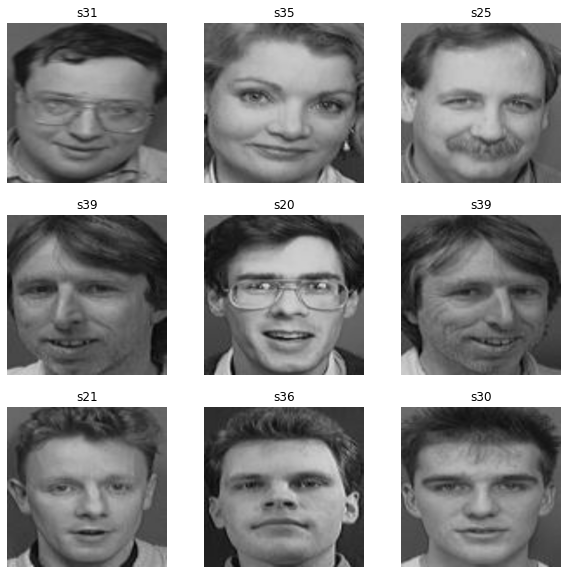

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_wholeimage = []
train_wholelabel = []

for images, labels in train_ds.unbatch().take(-1):
    train_wholeimage.append(images)
    train_wholelabel.append(labels)

In [ ]:
train_wholelabel= np.asarray(train_wholelabel, dtype=np.float32)
train_wholeimage = np.asarray(train_wholeimage, dtype=np.float32)

In [ ]:
val_wholeimage = []
val_wholelabel = []

for images, labels in val_ds.unbatch().take(-1):
    val_wholeimage.append(images)
    val_wholelabel.append(labels)

In [ ]:
val_wholelabel= np.asarray(val_wholelabel, dtype=np.float32)
val_wholeimage = np.asarray(val_wholeimage, dtype=np.float32)

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
train_wholelabel = train_wholelabel.astype("uint8")
val_wholelabel = val_wholelabel.astype("uint8")

In [ ]:
# make train pairs
pairs_train, labels_train = make_pairs(train_wholeimage, train_wholelabel)
# make validation pairs
pairs_val, labels_val = make_pairs(val_wholeimage, val_wholelabel)

In [ ]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

IMG_SHAPE = x_train_1.shape[1:]

In [ ]:
# input_layer = tf.keras.Input(shape=IMG_SHAPE)
# batchnormalizelayer = tf.keras.layers.BatchNormalization()
# base_model = tf.keras.applications.Xception(include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(40, activation="tanh")

# embedding_network = tf.keras.Sequential([
#   input_layer,
#   batchnormalizelayer,
#   base_model,
#   global_average_layer,
#   prediction_layer
# ])

# embedding_network.trainable = False
# embedding_network.summary()

In [ ]:
inputx = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.BatchNormalization()(inputx)
x = tf.keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(output_classes, activation="tanh")(x)
embedding_network = tf.keras.Model(inputx, x)

In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
input_1 = tf.keras.layers.Input(IMG_SHAPE)
input_2 = tf.keras.layers.Input(IMG_SHAPE)

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 40)           2621556     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/250
30/30 [==============================] - 6s 56ms/step - loss: 0.4178 - accuracy: 0.2021 - val_loss: 0.4589 - val_accuracy: 0.3917
Epoch 2/250
30/30 [==============================] - 1s 42ms/step - loss: 0.3909 - accuracy: 0.2583 - val_loss: 0.4092 - val_accuracy: 0.3750
Epoch 3/250
30/30 [==============================] - 1s 42ms/step - loss: 0.3871 - accuracy: 0.2438 - val_loss: 0.4119 - val_accuracy: 0.2167
Epoch 4/250
30/30 [==============================] - 1s 42ms/step - loss: 0.3785 - accuracy: 0.2479 - val_loss: 0.4024 - val_accuracy: 0.2667
Epoch 5/250
30/30 [==============================] - 1s 42ms/step - loss: 0.3734 - accuracy: 0.2458 - val_loss: 0.3727 - val_accuracy: 0.2417
Epoch 6/250
30/30 [==============================] - 1s 38ms/step - loss: 0.3620 - accuracy: 0.2271 - val_loss: 0.3624 - val_accuracy: 0.2333
Epoch 7/250
30/30 [==============================] - 1s 37ms/step - loss: 0.3463 - accuracy: 0.2542 - val_loss: 0.3561 - val_accuracy: 0.3000
Epoch 

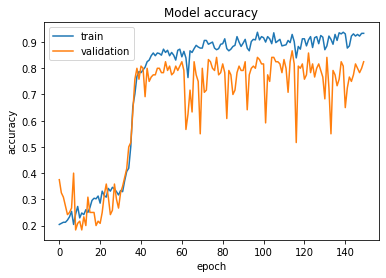

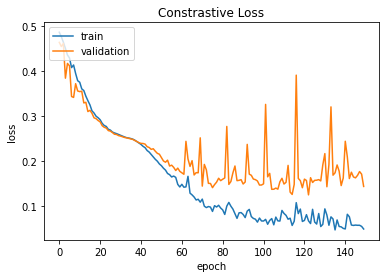

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [ ]:
results = siamese.evaluate([x_val_1, x_val_2], labels_val) #suppose is x_test_1
print("test loss, test acc:", results)

4/4 [==============================] - 0s 54ms/step - loss: 0.1434 - accuracy: 0.8250
test loss, test acc: [0.14339786767959595, 0.824999988079071]


In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col
    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        ax.imshow(tf.concat([pairs[i][0].astype(np.uint8), pairs[i][1].astype(np.uint8)], axis=1))

        # ax.imshow(np.squeeze([pairs[i][0]], axis=0))

        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [ ]:
predictions = siamese.predict([x_val_1, x_val_2])

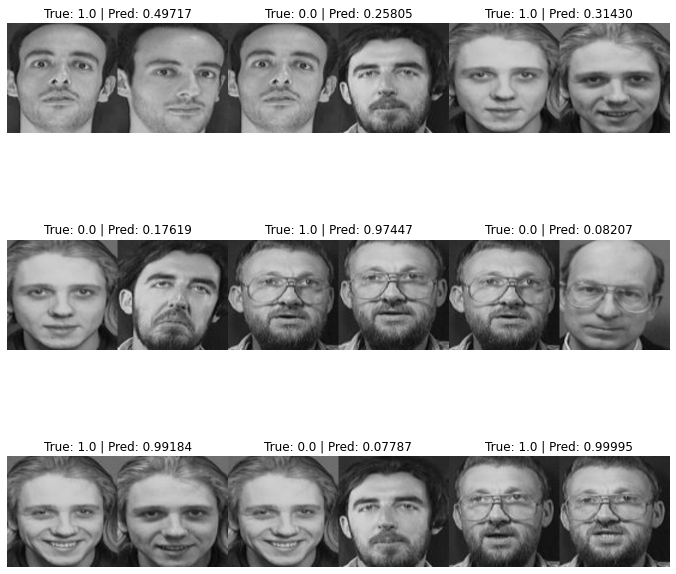

In [ ]:
visualize(pairs_val, labels_val, to_show=9, predictions=predictions, test=True)